In [1]:
install.packages('rugarch')
library(kableExtra)
library(tidyverse)
library(fpp3)
library(tidyquant)
library(rugarch)


The downloaded binary packages are in
	/var/folders/6c/vby383sn3xlg0j_c253f0sf40000gn/T//Rtmp3jjysn/downloaded_packages


── Attaching packages ─────────────────────────────────────── tidyverse 1.3.2 ──
✔ ggplot2 3.3.6     ✔ purrr   1.0.1
✔ tibble  3.1.8     ✔ dplyr   1.1.0
✔ tidyr   1.2.1     ✔ stringr 1.4.1
✔ readr   2.1.4     ✔ forcats 1.0.0
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter()     masks stats::filter()
✖ dplyr::group_rows() masks kableExtra::group_rows()
✖ dplyr::lag()        masks stats::lag()
── Attaching packages ────────────────────────────────────────────── fpp3 0.5 ──

✔ lubridate   1.9.2     ✔ feasts      0.3.0
✔ tsibble     1.1.3     ✔ fable       0.3.2
✔ tsibbledata 0.4.1     ✔ fabletools  0.3.2

── Conflicts ───────────────────────────────────────────────── fpp3_conflicts ──
✖ lubridate::date()    masks base::date()
✖ dplyr::filter()      masks stats::filter()
✖ dplyr::group_rows()  masks kableExtra::group_rows()
✖ tsibble::intersect() masks base::intersect()
✖ tsibble::interval()  masks lubridate::interval()
✖ dplyr::lag()       

## Univariate Models for Volatility
#### Motivating volatility time series models
Volatility is a fundamental variable in many areas of finance:
- Risk management
- Pricing of financial assets
- Hedging
- Option pricing
  * Univariate Models

In particular, we can: 
- model and forecast volatility (and conditional covariances/correlations, in the multivariate case)
- estimate more efficiently the parameters from the conditional mean equation (which establishes the model which plays the main role to obtain point forecasts);
- Establish correct point and interval forecasts for the variable of interest. In particular, if conditional heteroskedasticity is neglected, the prediction intervals will be incorrect.
#### Forecasting Time Series
- $R_{T+S|T}$ : foreacst you want to make s steps ahead obtained at time t for R (returns) at time t+s
- You want to make optimal forecasts, choose forecast that minimises MSE:
  - $min (MSE(R_{T+S|T})) = Var(\epsilon_{T+S|T}) = R_{T+S} - R_{T+S|T}$ ; s steps ahead forecast error
  - $R_{T+S|T} = E[R_{T+S} | I_T]$ ; Where its conditional on all the information you have 
  - The information set, I_T , includes the present and past information available and relevant to forecast
  - The relevant information available for the ARIMA models concerns the present and past values of the variable of interest Rt which implies
    - $\Rightarrow E[R_{T+S}|R_T, R_{T-1}, ...]$
    - For ADL models it also includes history of other variables revelant for returns
    - This formula then does not depend on volatlity $\sigma_t$
    - It playes a role in the prediction intervals, not for the point forecasts


#### Option Pricing
- Call Option: 
  - Contract that gives the right (but not the obligation) to buy a given financial asset at a fixed price until maturity (american) or at maturity date (european).
- Put Option:
  - Contract that gives the right (but not the obligation) to sell a given financial asset at a fixed price until maturity (american) or at maturity date (european).
- Black and Scholes (1972) and Merton (1973) extended the binomial model to continuous time and found the formula (BSM).
- From equation (1) we conclude that the price of financial options strongly depends on the asset volatility.
- In the BSM model, volatility is assumed constant which implies that it can be estimated by the historical standard deviation of returns

#### Portfolio Management
- Suppose that a financial practitioner wants to choose how much to invest in two different assets, say A e B, for the next periods. How to do it?
- A possibility is to build the efficient frontier. Here, he chooses the proportion to invest in asset A, $X_A$, and asset B, $X_B$, that minimizes the portfolio variance, $\sigma_P^2$, and achieves a fixed target expected return, $\mu_P$
- $P = X_A.A + X_B.B = X_A.A + (1-X_A).B$
- $min X_A Var(P) = X_A^2 . Var(A) + X_B^2.Var(B) + 2.X_A.X_B\sigma_{A,B} ;  s.t E(P) = \bar{\mu_p} = E[X_A.A + X_B.B]$
- 

In [2]:
stock <- tidyquant::tq_get(c("^GSPC","^N225","^IXIC","^NYA"), 
   get = "stock.prices" ,from="1990-01-01", to="2021-12-31") %>% 
  mutate(symbol = ifelse(symbol == "^GSPC","S&P500",symbol)) %>% 
  mutate(symbol = ifelse(symbol == "^N225","Nikkei",symbol)) %>% 
  mutate(symbol = ifelse(symbol == "^IXIC","NASDAQ",symbol)) %>% 
  mutate(symbol = ifelse(symbol == "^NYA","NYSE",symbol)) %>% 
  mutate(date = as_date(date)) %>% 
  as_tsibble(index = date,key = symbol) %>% 
  group_by_key() %>% 
  mutate(rtn = difference(log(close))) %>% 
  filter(!is.na(rtn)) %>% 
  group_by_key() %>% 
  mutate(trading_day = row_number()) 
stock %>% select(symbol,date,close,rtn)

symbol,date,close,rtn
<chr>,<date>,<dbl>,<dbl>
NASDAQ,1990-01-03,460.9,0.003477522
NASDAQ,1990-01-04,459.4,-0.003259810
NASDAQ,1990-01-05,458.2,-0.002615481
NASDAQ,1990-01-08,458.7,0.001090632
NASDAQ,1990-01-09,456.8,-0.004150796
NASDAQ,1990-01-10,450.7,-0.013443676
NASDAQ,1990-01-11,448.9,-0.004001824
NASDAQ,1990-01-12,439.7,-0.020707429
NASDAQ,1990-01-15,436.6,-0.007075246


#### Structure Of Model
- Decompose R_t as:
  - $r_t = E(r_t | I{t-1} + R_t - E(r_t | I{t-1}= E(r_t | I{t-1}) + \epsilon_t = \mu_t + \epsilon_t \Rightarrow$ Conditional Mean Equation
  - Until now, epsilon has been regarded as iid with mean 0, variance sigma^2
    - Now it will be defined as a product of two RV
    - 

## ARCH Models

In [3]:
IXICrtn <- stock %>% 
  filter(symbol == "NASDAQ") %>% 
  filter(!is.na(rtn)) %>% 
  pull(rtn)

IXICrtn <- 100*IXICrtn

spec <-  rugarch::ugarchspec(variance.model=list(model="sGARCH", 
                            garchOrder=c(11,0)),
                          mean.model=list(armaOrder=c(2,0), 
                                          include.mean=TRUE))

rugarch::ugarchfit(data = IXICrtn, spec = spec)



*---------------------------------*
*          GARCH Model Fit        *
*---------------------------------*

Conditional Variance Dynamics 	
-----------------------------------
GARCH Model	: sGARCH(11,0)
Mean Model	: ARFIMA(2,0,0)
Distribution	: norm 

Optimal Parameters
------------------------------------
         Estimate  Std. Error  t value Pr(>|t|)
mu       0.082752    0.010684   7.7451 0.000000
ar1      0.025684    0.011507   2.2321 0.025610
ar2     -0.016626    0.011982  -1.3876 0.165263
omega    0.292864    0.017664  16.5796 0.000000
alpha1   0.072188    0.012908   5.5925 0.000000
alpha2   0.146784    0.014701   9.9848 0.000000
alpha3   0.104626    0.014298   7.3174 0.000000
alpha4   0.113799    0.014552   7.8202 0.000000
alpha5   0.078666    0.013302   5.9138 0.000000
alpha6   0.091865    0.014227   6.4572 0.000000
alpha7   0.047613    0.012534   3.7988 0.000145
alpha8   0.048433    0.012460   3.8871 0.000101
alpha9   0.037709    0.011605   3.2494 0.001157
alpha10  0.066031 

In [4]:
spec <-  rugarch::ugarchspec(variance.model=list(model="sGARCH", 
                            garchOrder=c(11,0)),
                          mean.model=list(armaOrder=c(2,0), 
                                          include.mean=TRUE))

rugarch::ugarchfit(data = IXICrtn, spec = spec)



*---------------------------------*
*          GARCH Model Fit        *
*---------------------------------*

Conditional Variance Dynamics 	
-----------------------------------
GARCH Model	: sGARCH(11,0)
Mean Model	: ARFIMA(2,0,0)
Distribution	: norm 

Optimal Parameters
------------------------------------
         Estimate  Std. Error  t value Pr(>|t|)
mu       0.082752    0.010684   7.7451 0.000000
ar1      0.025684    0.011507   2.2321 0.025610
ar2     -0.016626    0.011982  -1.3876 0.165263
omega    0.292864    0.017664  16.5796 0.000000
alpha1   0.072188    0.012908   5.5925 0.000000
alpha2   0.146784    0.014701   9.9848 0.000000
alpha3   0.104626    0.014298   7.3174 0.000000
alpha4   0.113799    0.014552   7.8202 0.000000
alpha5   0.078666    0.013302   5.9138 0.000000
alpha6   0.091865    0.014227   6.4572 0.000000
alpha7   0.047613    0.012534   3.7988 0.000145
alpha8   0.048433    0.012460   3.8871 0.000101
alpha9   0.037709    0.011605   3.2494 0.001157
alpha10  0.066031 


*---------------------------------*
*          GARCH Model Fit        *
*---------------------------------*

Conditional Variance Dynamics 	
-----------------------------------
GARCH Model	: sGARCH(1,1)
Mean Model	: ARFIMA(2,0,0)
Distribution	: norm 

Optimal Parameters
------------------------------------
        Estimate  Std. Error  t value Pr(>|t|)
mu      0.081717    0.010878   7.5125 0.000000
ar1     0.028860    0.012031   2.3987 0.016451
ar2    -0.013713    0.011725  -1.1696 0.242167
omega   0.027680    0.003493   7.9240 0.000000
alpha1  0.108121    0.007841  13.7884 0.000000
beta1   0.877140    0.008465 103.6173 0.000000

Robust Standard Errors:
        Estimate  Std. Error  t value Pr(>|t|)
mu      0.081717    0.010971   7.4486 0.000000
ar1     0.028860    0.012120   2.3812 0.017257
ar2    -0.013713    0.011706  -1.1715 0.241391
omega   0.027680    0.005282   5.2407 0.000000
alpha1  0.108121    0.013648   7.9221 0.000000
beta1   0.877140    0.014454  60.6844 0.000000

LogLike


*---------------------------------*
*          GARCH Model Fit        *
*---------------------------------*

Conditional Variance Dynamics 	
-----------------------------------
GARCH Model	: sGARCH(1,1)
Mean Model	: ARFIMA(2,0,0)
Distribution	: norm 

Optimal Parameters
------------------------------------
        Estimate  Std. Error  t value Pr(>|t|)
mu      0.081717    0.010878   7.5125 0.000000
ar1     0.028860    0.012031   2.3987 0.016451
ar2    -0.013713    0.011725  -1.1696 0.242167
omega   0.027680    0.003493   7.9240 0.000000
alpha1  0.108121    0.007841  13.7884 0.000000
beta1   0.877140    0.008465 103.6173 0.000000

Robust Standard Errors:
        Estimate  Std. Error  t value Pr(>|t|)
mu      0.081717    0.010971   7.4486 0.000000
ar1     0.028860    0.012120   2.3812 0.017257
ar2    -0.013713    0.011706  -1.1715 0.241391
omega   0.027680    0.005282   5.2407 0.000000
alpha1  0.108121    0.013648   7.9221 0.000000
beta1   0.877140    0.014454  60.6844 0.000000

LogLike


*---------------------------------*
*          GARCH Model Fit        *
*---------------------------------*

Conditional Variance Dynamics 	
-----------------------------------
GARCH Model	: sGARCH(2,1)
Mean Model	: ARFIMA(1,0,0)
Distribution	: norm 

Optimal Parameters
------------------------------------
        Estimate  Std. Error  t value Pr(>|t|)
mu      0.080193    0.010962   7.3159 0.000000
ar1     0.026724    0.011681   2.2877 0.022152
omega   0.033745    0.004622   7.3009 0.000000
alpha1  0.075652    0.012929   5.8513 0.000000
alpha2  0.047334    0.016391   2.8879 0.003879
beta1   0.858822    0.011457  74.9622 0.000000

Robust Standard Errors:
        Estimate  Std. Error  t value Pr(>|t|)
mu      0.080193    0.011006   7.2864 0.000000
ar1     0.026724    0.011934   2.2393 0.025136
omega   0.033745    0.006979   4.8353 0.000001
alpha1  0.075652    0.018783   4.0276 0.000056
alpha2  0.047334    0.023750   1.9930 0.046263
beta1   0.858822    0.018769  45.7574 0.000000

LogLike


*---------------------------------*
*          GARCH Model Fit        *
*---------------------------------*

Conditional Variance Dynamics 	
-----------------------------------
GARCH Model	: sGARCH(2,1)
Mean Model	: ARFIMA(1,0,0)
Distribution	: norm 

Optimal Parameters
------------------------------------
        Estimate  Std. Error  t value Pr(>|t|)
mu      0.080193    0.010962   7.3159 0.000000
ar1     0.026724    0.011681   2.2877 0.022152
omega   0.033745    0.004622   7.3009 0.000000
alpha1  0.075652    0.012929   5.8513 0.000000
alpha2  0.047334    0.016391   2.8879 0.003879
beta1   0.858822    0.011457  74.9622 0.000000

Robust Standard Errors:
        Estimate  Std. Error  t value Pr(>|t|)
mu      0.080193    0.011006   7.2864 0.000000
ar1     0.026724    0.011934   2.2393 0.025136
omega   0.033745    0.006979   4.8353 0.000001
alpha1  0.075652    0.018783   4.0276 0.000056
alpha2  0.047334    0.023750   1.9930 0.046263
beta1   0.858822    0.018769  45.7574 0.000000

LogLike

Response variable not specified, automatically selected `var = value`
Response variable not specified, automatically selected `var = value`


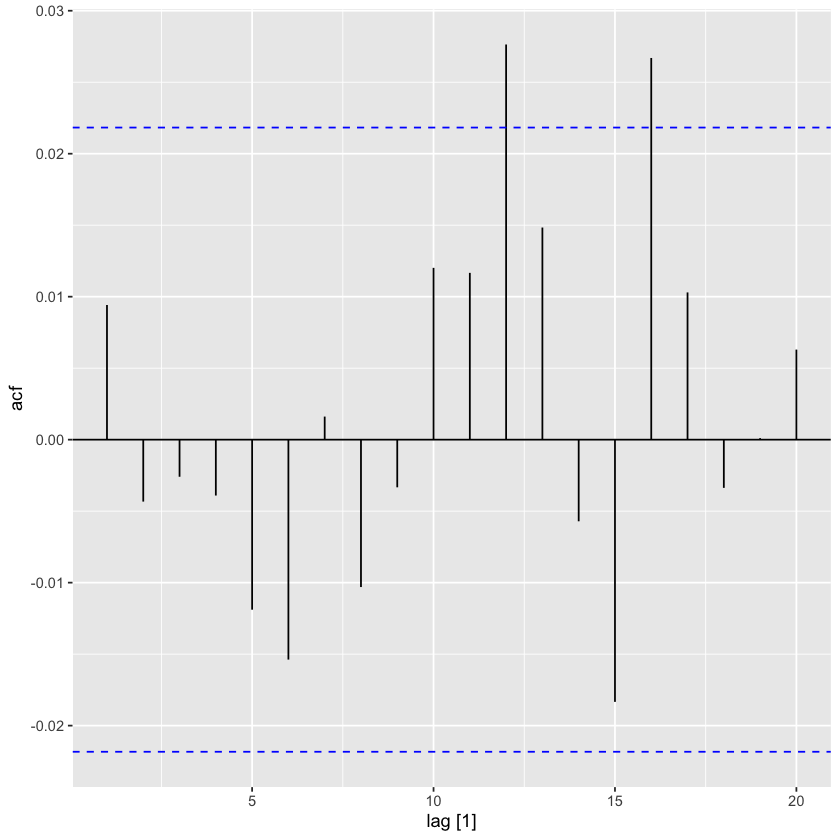

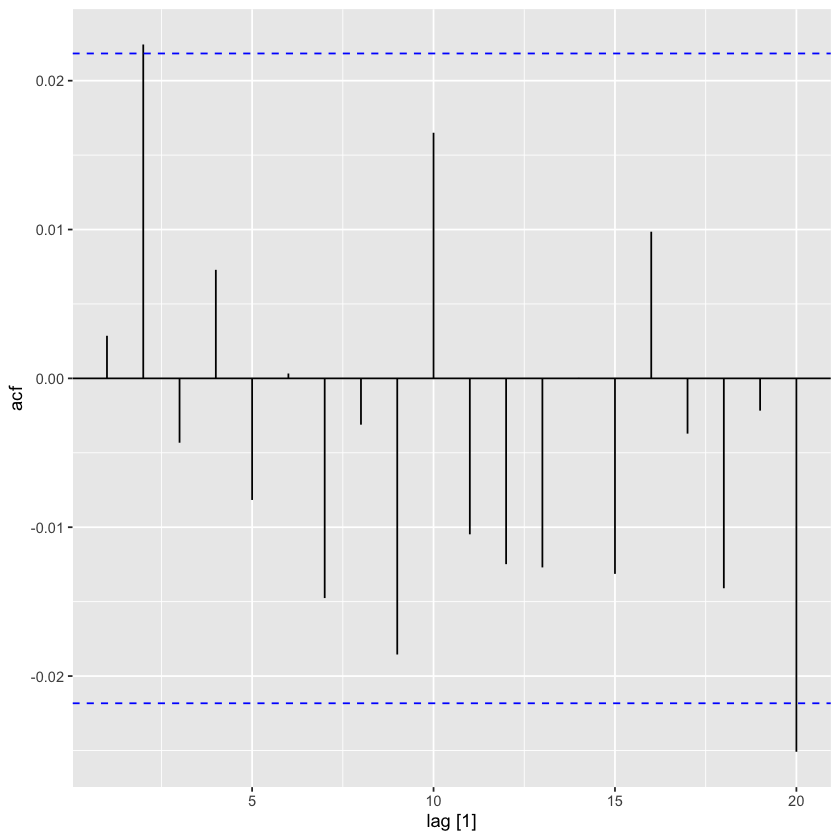

In [5]:


## ----echo=TRUE, results='hide',message=FALSE-------------------------------------------------
spec <-  rugarch::ugarchspec(variance.model=list(model="sGARCH", 
                            garchOrder=c(1,1)),
                          mean.model=list(armaOrder=c(2,0), 
                                          include.mean=TRUE))

rugarch::ugarchfit(data = IXICrtn, spec = spec)


## ---- echo=FALSE-----------------------------------------------------------------------------
spec <-  rugarch::ugarchspec(variance.model=list(model="sGARCH", 
                            garchOrder=c(1,1)),
                          mean.model=list(armaOrder=c(2,0), 
                                          include.mean=TRUE))
rugarch::ugarchfit(data = IXICrtn, spec = spec)


## ----echo=TRUE, results='hide',message=FALSE-------------------------------------------------
spec <-  rugarch::ugarchspec(variance.model=list(model="sGARCH", 
                             garchOrder=c(2,1)),
                        mean.model=list(armaOrder=c(1,0), 
                                        include.mean=TRUE))
rugarch::ugarchfit(data = IXICrtn, spec = spec)


## ---- echo=FALSE-----------------------------------------------------------------------------
spec <-  rugarch::ugarchspec(variance.model=list(model="sGARCH", 
                             garchOrder=c(2,1)),
                        mean.model=list(armaOrder=c(1,0), 
                                        include.mean=TRUE))

rugarch::ugarchfit(data = IXICrtn, spec = spec)


## ---- out.width="90%",  fig.align='center'---------------------------------------------------
fit <- rugarch::ugarchfit(data = IXICrtn, spec = spec)
fit@fit$z %>% ts() %>% as_tsibble() %>% 
  ACF(lag_max = 20) %>% autoplot()


## ---- out.width="90%",  fig.align='center'---------------------------------------------------
fit <- rugarch::ugarchfit(data = IXICrtn, spec = spec)
fit@fit$z^2 %>% ts() %>% as_tsibble() %>% 
  ACF(lag_max = 20) %>% autoplot()



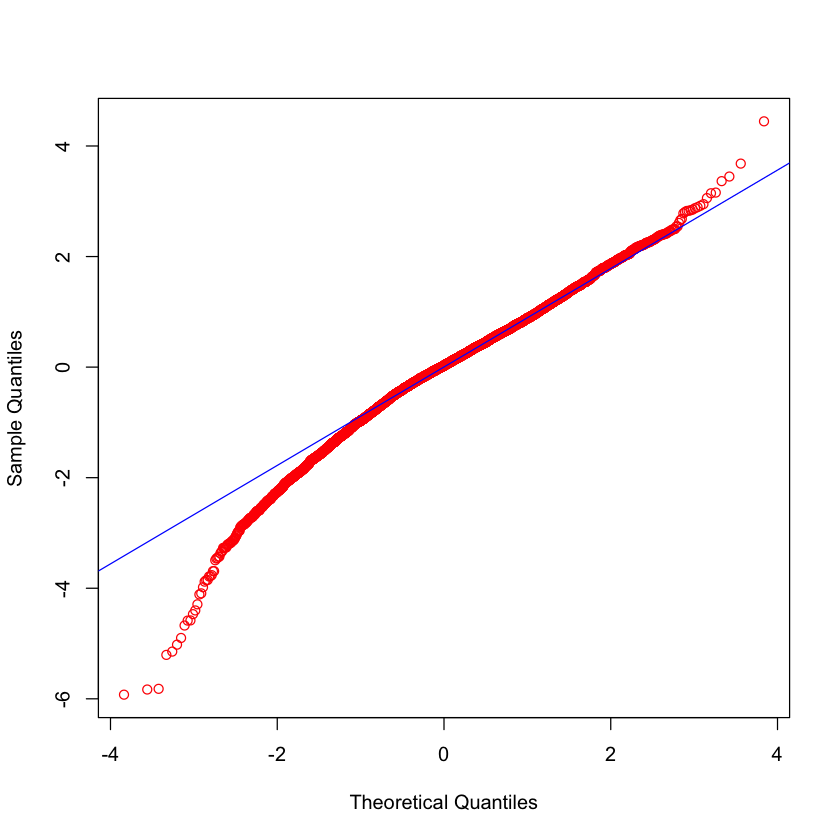

In [6]:
## ---- out.width="100%",  fig.align='center'--------------------------------------------------
qqnorm(fit@fit$z,main="",col="red")
qqline(fit@fit$z,col="blue")



Fitting the arma garch with normal distribution fails to capture the heavy tails
- $r_t = \mu_t +\epsilon_t , \epsilon_t = \sigma_t z_t, z_t ~ N(0,1)$
- $\sigma^2_t = \alpha_0 +\alpha_1 \epsilon_{t-1}^2 +\beta_1 \sigma_{t-1}^2$
- 

In [7]:
## ----echo=TRUE, results='hide',message=FALSE-------------------------------------------------
spec <-  rugarch::ugarchspec(variance.model=list(model="sGARCH", 
                             garchOrder=c(2,1)),
                    mean.model=list(armaOrder=c(1,0), 
                                    include.mean=TRUE))
fit <- rugarch::ugarchfit(data = IXICrtn, spec = spec)
rugarch::ugarchforecast(fit,n.ahead = 10)



*------------------------------------*
*       GARCH Model Forecast         *
*------------------------------------*
Model: sGARCH
Horizon: 10
Roll Steps: 0
Out of Sample: 0

0-roll forecast [T0=1992-01-28]:
      Series Sigma
T+1  0.07387 1.275
T+2  0.08002 1.247
T+3  0.08019 1.251
T+4  0.08019 1.253
T+5  0.08019 1.255
T+6  0.08019 1.256
T+7  0.08019 1.258
T+8  0.08019 1.260
T+9  0.08019 1.262
T+10 0.08019 1.264



- Many extensions to the GARCH model, more popular ones tend to change the distributions of the Z
### GARCH in Mean (GARCH-M)
- Adds an explanatory variable on the conditional mean equation:
  - $R_t = \mu_t +\delta g(\sigma_t^2) + \epsilon_t , \epsilon_t = \sigma_t z_t, z_t ~ N(0,1)$
  - X is target variable (volatility), no longer an arma model but an arma x model
  - It will be a function of the conditional variance
- here $\delta$ is positive, because given the risk return tradeoff, you expect it to be higher to explain the dynamics of the model. So if $\sigma_t^2$ is higher, you need the return to be higher. 
- Can test $H_0 : \delta = 0 \rightarrow$ no evidence of risk premium, else evidence of risk premium
- higher the risk, you should expect higher returns from the financial asset
- Could also be AR(1), or AR(2). 
- By adding the above term, you are allowing for autocorrelation, since it is no longer a white noise process. 
- You are allowing temporal dependance via the GARCH model. So the return is now a sum of an uncorrelated process and a correlated process, allowing $corr(R_t, R_{t-k}) \ne 0$
- Can also change the distributions

In [9]:
spec <-  rugarch::ugarchspec(variance.model=list(model="sGARCH",
                                                 garchOrder=c(1,1)),
                             mean.model=list(armaOrder=c(1,0),
                                             include.mean=TRUE,
                                             archm=TRUE))
rugarch::ugarchfit(data = IXICrtn, spec = spec)



*---------------------------------*
*          GARCH Model Fit        *
*---------------------------------*

Conditional Variance Dynamics 	
-----------------------------------
GARCH Model	: sGARCH(1,1)
Mean Model	: ARFIMA(1,0,0)
Distribution	: norm 

Optimal Parameters
------------------------------------
        Estimate  Std. Error   t value Pr(>|t|)
mu     -0.008938    0.033027  -0.27061 0.786689
ar1     0.029097    0.012018   2.42101 0.015478
archm   0.096375    0.033081   2.91328 0.003577
omega   0.028028    0.003538   7.92129 0.000000
alpha1  0.109413    0.007924  13.80745 0.000000
beta1   0.875701    0.008553 102.38264 0.000000

Robust Standard Errors:
        Estimate  Std. Error  t value Pr(>|t|)
mu     -0.008938    0.033164  -0.2695 0.787549
ar1     0.029097    0.011905   2.4440 0.014526
archm   0.096375    0.032834   2.9352 0.003333
omega   0.028028    0.005289   5.2997 0.000000
alpha1  0.109413    0.013533   8.0849 0.000000
beta1   0.875701    0.014388  60.8638 0.000000



- So in the above results, we do find evidence of risk premium. This is because due to the large number of the observations we approximate the statistic to a Z score, where the one sided 5% z score is 1.645. 

##### News Impact Curve
- $NIC(\epsilon_t | I_{t-1}) = NIC(\epsilon_t|\sigma_t^2 = \sigma^2) = \alpha_0 +\alpha_1\epsilon_{t-1}^2 +\beta_1\sigma^2_{t-1} = \alpha_0+\beta_1\sigma^2 = \alpha_1\epsilon_{t-1}^2 = A +  \alpha_1\epsilon_{t-1}^2$
- How does volatility react according to shock